In [7]:
import math
def rgb_to_yuv(R,G,B):
    """
    Converts an RGB image to YUV using the BT.601 standard.
    Need to CLIP!!!
    """
    Y = 0.299 * R + 0.587 * G + 0.114 * B
    U = (B - Y) * 0.492 + 128
    V = (R - Y) * 0.877 + 128
    return Y,U,V

def yuv_to_rgb(Y, U, V):
    """
    Converts a YUV image back to RGB using the BT.601 standard.
    """
    R = Y + 1.140 * (V - 128)
    G = Y - 0.394 * (U - 128) - 0.581 * (V - 128)
    B = Y + 2.032 * (U - 128)
    
    return R, G, B

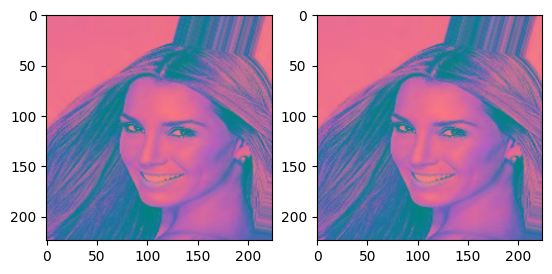

(121.47092235331633, 0.9999135273296463)

In [8]:
import sys
sys.path.append('../')
import numpy as np
import torch
import PIL.Image
from tools.img import rgb2yuv
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity

img = PIL.Image.open('../resource/example/000001.jpg').resize((224, 224))
x_nd = np.array(img).astype(np.uint8)
x_yuv_1 = np.zeros_like(x_nd)
x_yuv_1 = np.stack(rgb_to_yuv(x_nd[:, :, 0], x_nd[:, :, 1], x_nd[:, :, 2]), -1)
x_yuv_1 = np.clip(x_yuv_1, 0, 255)
x_yuv_1 = x_yuv_1.astype(np.uint8)

x_yuv_2 = rgb2yuv(x_nd).astype(np.uint8)

_, ax = plt.subplots(1, 2)
ax[0].imshow(x_yuv_1)
ax[1].imshow(x_yuv_2)
plt.show()

(x_yuv_1 - x_yuv_2).mean(), structural_similarity(x_yuv_1, x_yuv_2, win_size=3, data_range=1)


In [9]:
x_fft_1 = np.fft.fft2(x_yuv_1[:, :, 1])
x_fft_2 = np.fft.fft2(x_yuv_2[:, :, 1])

(x_fft_1.imag - x_fft_2.imag).mean()

-6.887914275225461e-16

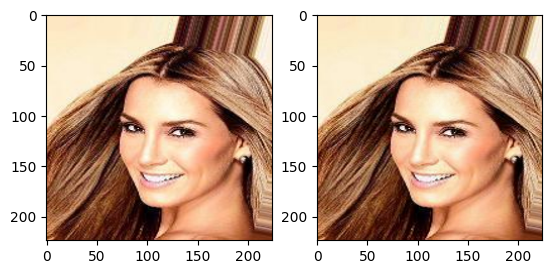

(211.79599144345238, 0.9989193111186673)

In [10]:
x_yuv_1 = x_yuv_1.astype(float)
x_rgb = np.stack(yuv_to_rgb(x_yuv_1[:,:,0], x_yuv_1[:,:,1], x_yuv_1[:,:,2]), 2)
x_rgb = np.clip(x_rgb, 0, 255)
x_rgb = x_rgb.astype(np.uint8)
_, ax = plt.subplots(1, 2)
ax[0].imshow(x_nd)
ax[1].imshow(x_rgb)
plt.show()
(x_rgb - x_nd).mean(), structural_similarity(x_rgb, x_nd, win_size=3, data_range=1)

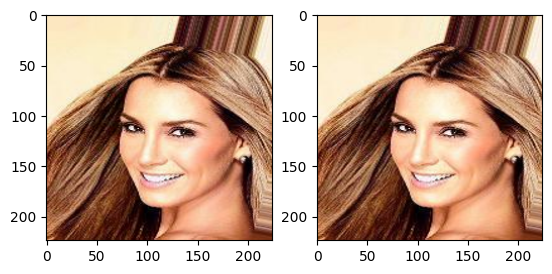

0.9984263243454939

In [18]:
from tools.img import tensor2ndarray, ndarray2tensor
from tools.img import rgb_to_yuv, yuv_to_rgb

x_torch = ndarray2tensor(x_nd) * 255.
x_yuv = torch.stack(rgb_to_yuv(x_torch[0], x_torch[1], x_torch[2]), dim=0)
x_yuv = torch.clip(x_yuv, 0, 255)

# inject trigger
x_fft = torch.fft.fft2(x_yuv[1])
x_image = torch.imag(x_fft)
x_image[0:3, 0:3] = 0
x_fft = torch.real(x_fft) + 1j * x_image
x_yuv[1] = torch.real(torch.fft.ifft2(x_fft))

x_rgb = torch.stack(yuv_to_rgb(x_yuv[0], x_yuv[1], x_yuv[2]), dim=0)
x_rgb = torch.clip(x_rgb, 0, 255)
x_rgb /= 255.
x_rgb =tensor2ndarray(x_rgb)
x_rgb = np.clip(x_rgb, 0, 255).astype(np.uint8)

_, ax = plt.subplots(1, 2)
ax[0].imshow(x_rgb)
ax[1].imshow(x_nd)

plt.show()

structural_similarity(x_rgb, x_nd, win_size=3)

Conclusion: cv2.COLOR_RGB2YUV is BT.601 standard!